<img src="../logo_skmob.png" width=250 align="left"/>

# Trajectory models

Generative models of individual trajectories

In [79]:
import skmob
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Exploration and Preferential Return EPR

### Density EPR

In [80]:
from skmob.models.epr import DensityEPR

In [81]:
tessellation = gpd.GeoDataFrame.from_file("data/NY_counties_2011.geojson")
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')

In [83]:
depr = DensityEPR()

In [84]:
tdf = depr.generate(start_time, end_time, tessellation, 
                    relevance_column='population',
                    n_agents=100, od_matrix=None, verbose=True)

100%|██████████| 100/100 [00:05<00:00, 21.34it/s]


In [87]:
print(type(tdf))
tdf.parameters

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


{'model': {'class': <function skmob.models.epr.DensityEPR.__init__(self, name='Density EPR model')>,
  'generate': {'start_date': Timestamp('2019-01-01 08:00:00'),
   'end_date': Timestamp('2019-01-14 08:00:00'),
   'gravity_singly': {},
   'n_agents': 100,
   'relevance_column': 'population',
   'random_state': None,
   'verbose': True}}}

In [88]:
tdf.head() 

,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00.000000,44.647782,-73.506481
1,1,2019-01-01 09:34:31.218693,43.090260,-73.723446
2,1,2019-01-01 11:39:19.283539,43.090260,-73.723446
3,1,2019-01-01 16:04:12.768894,43.090260,-73.723446
4,1,2019-01-01 16:54:05.140444,42.798509,-73.565766


In [89]:
from skmob.preprocessing import detection, clustering
dtdf = detection.stops(tdf)
ctdf = clustering.cluster(dtdf)

In [90]:
uid = 2
m = tdf[tdf['uid'] == uid].plot_trajectory(zoom=7)
ctdf[ctdf['uid'] == uid].plot_stops(map_f=m)

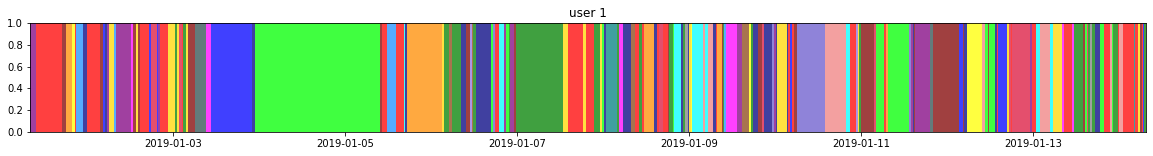

In [93]:
ax = ctdf.plot_diary(user=1)

Now that we have a TrajDataFrame, we can compute the individual and collective measures

In [97]:
from skmob.measures.individual import jump_lengths
from skmob.measures.individual import radius_of_gyration, waiting_times

In [98]:
jls = jump_lengths(tdf, merge=True)
jls[:5]

100%|██████████| 100/100 [00:00<00:00, 300.43it/s]


[174.05948737584822, 0.0, 0.0, 34.887811419816124, 252.08327809083718]

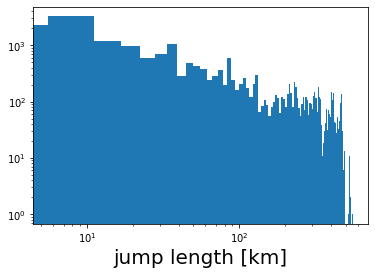

In [99]:
plt.hist(jls, bins=100)
plt.xlabel('jump length [km]', fontsize=20)
plt.loglog()
plt.show()

In [101]:
wts = waiting_times(tdf, merge=True)
wts[:5]

100%|██████████| 100/100 [00:00<00:00, 554.83it/s]


[5671.0, 7488.0, 15893.0, 2992.0, 4109.0]

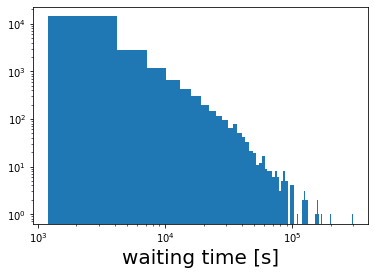

In [102]:
plt.hist(wts, bins=100)
plt.xlabel('waiting time [s]', fontsize=20)
plt.loglog()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 377.76it/s]


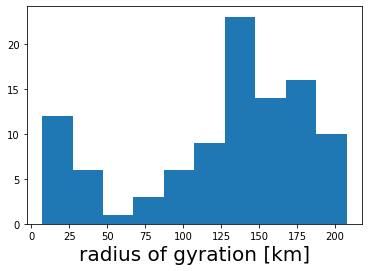

In [103]:
rg_df = radius_of_gyration(tdf)
plt.hist(rg_df.radius_of_gyration.values, bins=10)
plt.xlabel('radius of gyration [km]', fontsize=20)
plt.show()

### DITRAS

In [104]:
from skmob.models.epr import Ditras
from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import filtering, compression, detection, clustering

In [105]:
tdf = skmob.TrajDataFrame.from_file('./data/geolife_sample.txt.gz', 
                                     latitude='lat', longitude='lon', user_id='user', 
                                     datetime='datetime', sep=',')
ctdf = compression.compress(tdf)
stdf = detection.stops(ctdf)
cstdf = clustering.cluster(stdf)
cstdf[:5]

,lat,lng,datetime,uid,leaving_datetime,cluster
0,39.978253,116.327275,2008-10-23 06:01:05,1,2008-10-23 10:32:53,0
1,40.013819,116.306532,2008-10-23 11:10:09,1,2008-10-23 23:46:02,1
2,39.978987,116.326686,2008-10-24 00:10:39,1,2008-10-24 01:48:57,0
3,39.981316,116.310181,2008-10-24 01:56:47,1,2008-10-24 03:21:09,7
4,39.979580,116.313649,2008-10-24 03:26:35,1,2008-10-24 03:50:36,42


In [106]:
mdg = MarkovDiaryGenerator()
mdg.fit(cstdf, 2, lid='cluster')

100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


In [107]:
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')
ditras = Ditras(mdg)

In [109]:
tdf = ditras.generate(start_time, end_time, tessellation, relevance_column='population',
                    n_agents=3, od_matrix=None, verbose=True)

100%|██████████| 3/3 [00:00<00:00, 14.86it/s]


In [110]:
tdf.head()

,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00,42.757490,-77.791129
1,1,2019-01-02 03:00:00,42.757490,-77.791129
2,1,2019-01-02 17:00:00,43.151007,-76.097049
3,1,2019-01-02 18:00:00,42.757490,-77.791129
4,1,2019-01-03 02:00:00,42.757490,-77.791129


In [111]:
dtdf = detection.stops(tdf)
ctdf = clustering.cluster(dtdf)

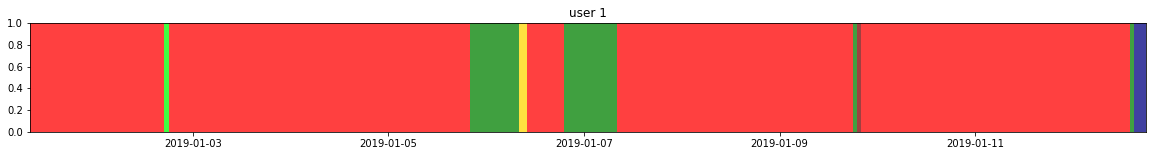

In [112]:
ax = ctdf.plot_diary(user=1)